# Traditional machine learning algorithms


Install optuna

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 209 kB 24.2 MB/s 
     |████████████████████████████████| 80 kB 5.2 MB/s 
     |████████████████████████████████| 75 kB 2.5 MB/s 
     |████████████████████████████████| 149 kB 24.4 MB/s 
     |████████████████████████████████| 112 kB 38.7 MB/s 
     |████████████████████████████████| 49 kB 3.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=e4a5d774f1119c374210dac3044b9f74f55ec5a91671e3949c1365943c3758c6
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


Then we import the necessary libraries.

In [ ]:
# Import libraries
import numpy as np
import optuna
import matplotlib
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

%matplotlib inline

We load the data

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load the train, validation and test data

# Train data (with images)
traindata = pd.read_csv('/content/gdrive/MyDrive/TFM/multimodal_train.tsv',sep='\t')
# Validation data (with images)
validata = pd.read_csv('/content/gdrive/MyDrive/TFM/multimodal_validate.tsv',sep='\t')
# Test data (with  images)
testdata = pd.read_csv('/content/gdrive/MyDrive/TFM/multimodal_test_public.tsv',sep='\t')


# Train data (with and without  images)
traindata_all = pd.read_csv('/content/gdrive/MyDrive/TFM/all_train.tsv',sep='\t')
# Validation data (with and without images images)
validata_all = pd.read_csv('/content/gdrive/MyDrive/TFM/all_validate.tsv',sep='\t')
# Test data (with and without images)
testdata_all = pd.read_csv('/content/gdrive/MyDrive/TFM/all_test_public.tsv',sep='\t')

We can check the number of train, vaidation and test instances in each dataset.

In [ ]:
print("Number of train instances for all data: ", len(traindata_all))
print("Number of validation instances for all data: ", len(validata_all))
print("Number of test instances for all data: ", len(testdata_all))

Number of train instances for all data:  878218
Number of validation instances for all data:  92444
Number of test instances for all data:  92444


In [ ]:
print("Number of train instances for multimodal data: ", len(traindata))
print("Number of validation instances for multimodal data: ", len(validata))
print("Number of test instances for multimodal data: ", len(testdata))

Number of train instances for multimodal data:  564000
Number of validation instances for multimodal data:  59342
Number of test instances for multimodal data:  59319


|Type of dataset| Train instances | Validation instances | Test instances |
|---------------|-----------------|----------------------|----------------|
| Multimodal | 564000| 59342 |59319 |
| Unimodal (all data) |878218 | 92444   |92444 |


As we can see they are dataframes.

In [ ]:
traindata.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


We check that the train, validation and test sets (that is, the **multimodal_train**, **multimodal_vaidate** and **multimodal_test_pulic** sets)  all have corresponding images.

In [ ]:
print("Number of train instances that have images: ",len(traindata[traindata['hasImage'] == True]))
print("Number of validation instances that have images: ",len(validata[validata['hasImage'] == True]))
print("Number of test instances that have images: ",len(testdata[testdata['hasImage'] == True]))

Number of train instances that have images:  564000
Number of validation instances that have images:  59342
Number of test instances that have images:  59319


We do this same check with the data contained in **all_train**, **all_validate** and **all_test_public** datasets. 

In [ ]:
print("Number of train instances that don`t have images: ",len(traindata_all[traindata_all['hasImage'] == False]))
print("Number of validation instances don't that have images: ",len(validata_all[validata_all['hasImage'] == False]))
print("Number of test instances that don`t have images: ",len(testdata_all[testdata_all['hasImage'] == False]))

Number of train instances that don`t have images:  239117
Number of validation instances don't that have images:  25236
Number of test instances that don`t have images:  25189


As we can see the number of  instances without images is equal to **239117** in the train data, **25236** in the validation data and **25189** in the test data. In the follwing cells we plot the class distribution for the multimodal and unimodal (all data) datastets. As we saw before there are missing values in the **clean_title** column, therefore we will first remove those rows that contain missing values for that column.

In [8]:

# MULTIMODAL DATASET
# Train data with no missing values
train_data = traindata[traindata['clean_title'].notnull().to_numpy()]
# Validation data with no missing values
valid_data = validata[validata['clean_title'].notnull().to_numpy()]
# Test data with no missing values
test_data = testdata[testdata['clean_title'].notnull().to_numpy()]

# UNIMODAL DATASET
train_data_all = traindata_all[traindata_all['clean_title'].notnull().to_numpy()]
# Validation data with no missing values
valid_data_all = validata_all[validata_all['clean_title'].notnull().to_numpy()]
# Test data with no missing values
test_data_all = testdata_all[testdata_all['clean_title'].notnull().to_numpy()]

In [9]:
# Get series object with the necessary columns

# MULTIMODAL DATASET
# Train data (text and labels)
train_frame = train_data["clean_title"]
train_labels = train_data["6_way_label"]
# Validation data (text and labels)
valid_frame = valid_data["clean_title"]
valid_labels = valid_data["6_way_label"]
# Test data (text and labels)
test_frame = test_data["clean_title"]
test_labels = test_data["6_way_label"]

# UNIMODAL DATASET
train_frame_all = train_data_all["clean_title"]
train_labels_all = train_data_all["6_way_label"]
# Validation data (text and labels)
valid_frame_all = valid_data_all["clean_title"]
valid_labels_all = valid_data_all["6_way_label"]
# Test data (text and labels)
test_frame_all = test_data_all["clean_title"]
test_labels_all = test_data_all["6_way_label"]

### Class distribution for the unimodal dataset

#### Train partition

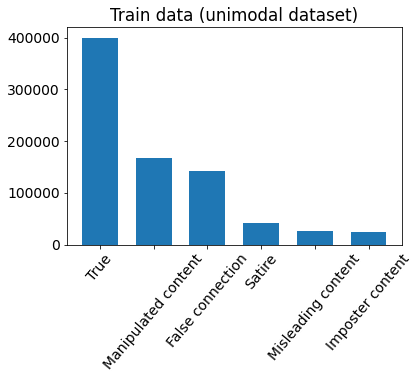

In [12]:
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)
# Train labels barplot
labs = train_labels_all.value_counts()
labels = ['True','Manipulated content','False connection','Satire','Misleading content','Imposter content']
x_pos_labels = [1, 4, 7, 10, 13, 16]
x_pos_labs = [1, 4, 7, 10, 13, 16]
plt.xticks(x_pos_labels, labels)
plt.bar(x_pos_labs, height = labs, width = 2 )
plt.title("Train data (unimodal dataset)")
plt.xticks(rotation=50)
plt.show()

#### Validation data

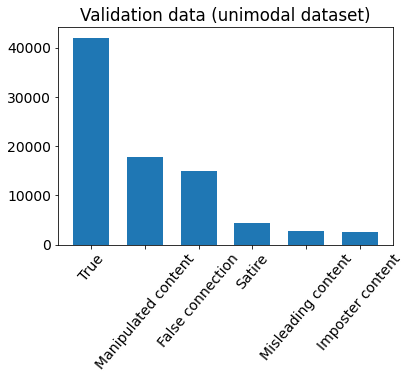

In [13]:
font = {'size'   : 14}

matplotlib.rc('font', **font)
# Train labels barplot
labs = valid_labels_all.value_counts()
labels = ['True','Manipulated content','False connection','Satire','Misleading content','Imposter content']
x_pos_labels = [1, 4, 7, 10, 13, 16]
x_pos_labs = [1, 4, 7, 10, 13, 16]
plt.xticks(x_pos_labels, labels)
plt.bar(x_pos_labs, height = labs, width = 2 )
plt.title("Validation data (unimodal dataset)")
plt.xticks(rotation=50)
plt.show()

#### Test data

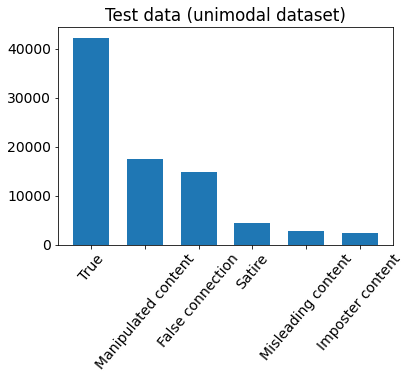

In [14]:
font = {'size'   : 14}

matplotlib.rc('font', **font)
# Train labels barplot
labs = test_labels_all.value_counts()
labels = ['True','Manipulated content','False connection','Satire','Misleading content','Imposter content']
x_pos_labels = [1, 4, 7, 10, 13, 16]
x_pos_labs = [1, 4, 7, 10, 13, 16]
plt.xticks(x_pos_labels, labels)
plt.bar(x_pos_labs, height = labs, width = 2 )
plt.title("Test data (unimodal dataset)")
plt.xticks(rotation=50)
plt.show()

### Class distribution for the multimodal dataset

#### Train data

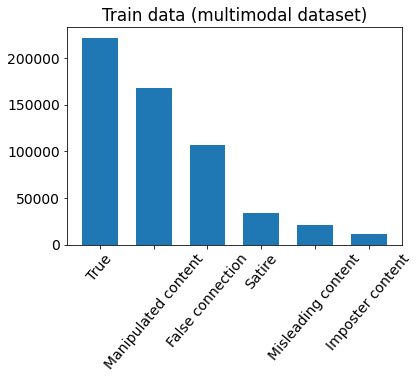

In [15]:
font = {'size'   : 14}

matplotlib.rc('font', **font)
# Train labels barplot
labs = train_labels.value_counts()
labels = ['True','Manipulated content','False connection','Satire','Misleading content','Imposter content']
x_pos_labels = [1, 4, 7, 10, 13, 16]
x_pos_labs = [1, 4, 7, 10, 13, 16]
plt.xticks(x_pos_labels, labels)
plt.bar(x_pos_labs, height = labs, width = 2 )
plt.title("Train data (multimodal dataset)")
plt.xticks(rotation=50)
plt.show()

#### Validation data

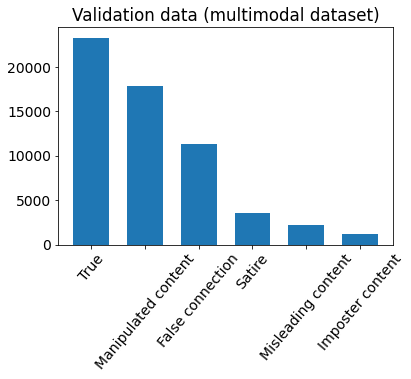

In [16]:
font = {'size'   : 14}

matplotlib.rc('font', **font)
# Train labels barplot
labs = valid_labels.value_counts()
labels = ['True','Manipulated content','False connection','Satire','Misleading content','Imposter content']
x_pos_labels = [1, 4, 7, 10, 13, 16]
x_pos_labs = [1, 4, 7, 10, 13, 16]
plt.xticks(x_pos_labels, labels)
plt.bar(x_pos_labs, height = labs, width = 2 )
plt.title("Validation data (multimodal dataset)")
plt.xticks(rotation=50)
plt.show()

#### Test data

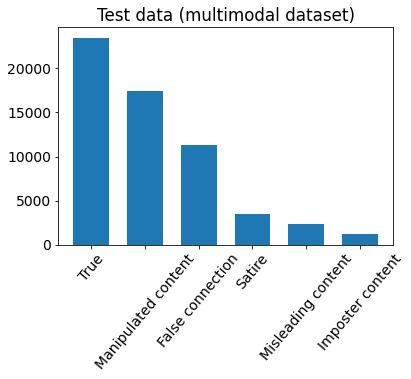

In [17]:
font = {'size'   : 14}

matplotlib.rc('font', **font)
# Train labels barplot
labs = test_labels.value_counts()
labels = ['True','Manipulated content','False connection','Satire','Misleading content','Imposter content']
x_pos_labels = [1, 4, 7, 10, 13, 16]
x_pos_labs = [1, 4, 7, 10, 13, 16]
plt.xticks(x_pos_labels, labels)
plt.bar(x_pos_labs, height = labs, width = 2 )
plt.title("Test data (multimodal dataset)")
plt.xticks(rotation=50)
plt.show()

We will use only the multimodal dataset, that is, the dataset that has no instances without a corresponding image.

## Multi-Class Text Classification


In this subsection we will prepare the data that we will use later on both to create the tf-idf matrix as well as to do hyper-parameter tuning, choose the best version of each model and finally compare these versions by using the test set. In order to train and evaluate the models we only need the orginal title of each new and the corresponding label of each new. We obtain that with the following code.

In [18]:
# Get series object with the necessary columns

# Train data (text and labels)
train_frame = train_data["clean_title"]
train_labels = train_data["6_way_label"]
# Validation data (text and labels)
valid_frame = valid_data["clean_title"]
valid_labels = valid_data["6_way_label"]
# Test data (text and labels)
test_frame = test_data["clean_title"]
test_labels = test_data["6_way_label"]

In [19]:
labels = ['True','Satire','False connection','Imposter content','Manipulated content','Misleading content']
# Train data
train_0 = sum(train_labels == 0)/len(train_labels)
train_1 = sum(train_labels == 1)/len(train_labels)
train_2 = sum(train_labels == 2)/len(train_labels)
train_3 = sum(train_labels == 3)/len(train_labels)
train_4 = sum(train_labels == 4)/len(train_labels)
train_5 = sum(train_labels == 5)/len(train_labels)
# Validation data
validation_0 = sum(valid_labels == 0)/len(valid_labels)
validation_1 = sum(valid_labels == 1)/len(valid_labels)
validation_2 = sum(valid_labels == 2)/len(valid_labels)
validation_3 = sum(valid_labels == 3)/len(valid_labels)
validation_4 = sum(valid_labels == 4)/len(valid_labels)
validation_5 = sum(valid_labels == 5)/len(valid_labels)
# Test data
test_0 = sum(test_labels == 0)/len(test_labels)
test_1 = sum(test_labels == 1)/len(test_labels)
test_2 = sum(test_labels == 2)/len(test_labels)
test_3 = sum(test_labels == 3)/len(test_labels)
test_4 = sum(test_labels == 4)/len(test_labels)
test_5 = sum(test_labels == 5)/len(test_labels)

d = {"Label":labels, "Traindata": [train_0, train_1, train_2, train_3, train_4, train_5], 
                  "Validata": [validation_0, validation_1, validation_2, validation_3, validation_4, validation_5],
                  "Testdata": [test_0, test_1, test_2, test_3, test_4, test_5]}

proportion_data = pd.DataFrame(data = d)
proportion_data

,Label,Traindata,Validata,Testdata
0,True,0.393761,0.392976,0.396281
1,Satire,0.059363,0.059334,0.059239
2,False connection,0.190108,0.190034,0.190445
3,Imposter content,0.020894,0.020862,0.020634
4,Manipulated content,0.297619,0.300125,0.294543
5,Misleading content,0.038255,0.036669,0.038858


As we can see the **3** datasets are unbalanced but  the proportions of the different labels are very similar in the 3 cases.


The next step is to clean the title of each new by removing stopwords from it and applying either stemming or lemmatization. We also remove  words that contain numbers, puntuaction, etc.


## Hyperparameter tuning

In this subsection we will use the train and validation sets in order to choose the version of the Naive Bayes, Logistic Regression, Random Forest and LinearSVC which delivers the best results. In order to do that we train several different versions of the same models (changing the values of the hyper-parameters) and we will obtain their accuracy by using the valdation set. We will use the optuna module in order to perform hyper-parameter tuning.

We will perform hyper-parameter tuning in **2** situations: in the first case we will apply stemming to the tokenized text and in the other case we will apply lemmatization. When performing model evaluation, we will compare the accuracy of all the models in both of the previous approaches.

### Preprocessing

First we remove punctuations and numbers and also multiple spaces


In [ ]:
# Convert 'series' data to list

## Texts ##

# Train
train_list = list(train_frame)
# Valid
valid_list = list(valid_frame)
# Test
test_list = list(test_frame)

## Labels ##

# Train
train_labels_list = list(train_labels)
# Valid
valid_labels_list = list(valid_labels)
# Test
test_labels_list = list(test_labels)

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
# Remove puntuations and numbers and multiple spaces

train_news_clean_1 = []
valid_news_clean_1 = []
test_news_clean_1 = []
# Train
for new in train_list:
    train_news_clean_1.append(preprocess_text(new))
# Validation
for new in valid_list:
    valid_news_clean_1.append(preprocess_text(new))
# Test
for new in test_list:
    test_news_clean_1.append(preprocess_text(new))

### Stemmed and lemmatized data

We obtain the stemmed and lemmatized data

#### Stemmed data

Function to remove stop words and perform stemming

In [ ]:
# Initialize stemmer and stop_words
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english')) 

# Function to remove stopwords
def remove_stopwords_stem(text):
    text = word_tokenize(text)
    # Stop words removal
    text = [word for word in text if word not in stop_words]
    # Stemming
    stemmed_text = [stemmer.stem(word) for word in text]    
    text_done = ' '.join(stemmed_text)
    return text_done

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We remove stop words and perform stemming

In [ ]:
# Train stemmed
train_stemmed = [remove_stopwords_stem(text) for text in train_news_clean_1]
# Validation stemmed
valid_stemmed = [remove_stopwords_stem(text) for text in valid_news_clean_1]
# Test stemmed
test_stemmed = [remove_stopwords_stem(text) for text in test_news_clean_1]

#### Lemmatized data

Function to remove stop words and perform lemmatization

In [ ]:
# Initialize lemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Initialize stemmer and stop_words
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english')) 

# Function to remove stopwords
def remove_stopwords_lem(text):
    text = word_tokenize(text)
    # Stop words removal
    text = [word for word in text if word not in stop_words]
    # Lematization
    lemmatized_text = []
    for word in text:
        word1 = lemmatizer.lemmatize(word, pos = "n")
        word2 = lemmatizer.lemmatize(word1, pos = "v")
        word3 = lemmatizer.lemmatize(word2, pos = ("a"))
        lemmatized_text.append(word3) 
    text_done = ' '.join(lemmatized_text)
    return text_done

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We remove stop words and perform lemmatiztion

In [ ]:
# Train lemmatized
train_lemmatized = [remove_stopwords_lem(text) for text in train_news_clean_1]
# Validation lemmatized
valid_lemmatized = [remove_stopwords_lem(text) for text in valid_news_clean_1]
# Test lemmatized
test_lemmatized = [remove_stopwords_lem(text) for text in test_news_clean_1]

### Stemming

#### Multinomial Naive Bayes

In [ ]:
### HPO with optuna ####

import optuna

# Define function to be optimized
def objective_Bayes(trial):
    
    # Sample values for the hyper-parameters
    n = trial.suggest_int("n", 1, 2)
    sub_tf = trial.suggest_categorical("sub_tf", ["True", "False"])
    min_df = trial.suggest_int("min_df",5,25)
    # Create pipeline
    Bayes_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, n), min_df = min_df)),
                            ('tfidf', TfidfTransformer(sublinear_tf = sub_tf)),('classifier', MultinomialNB() )])
    # Fit model
    clf_Bayes = Bayes_pipe.fit(train_stemmed, train_labels_list)
    # Obtain the predictions
    predictions = Bayes_pipe.predict(valid_stemmed)
    # Obtain the accuracy
    acc = accuracy_score(valid_labels_list, predictions)
    
    return acc

# Select budget and set seed                            
budget = 40
np.random.seed(0)
# Optimize hyper-parameters
study_Bayes = optuna.create_study(direction="maximize")
study_Bayes.optimize(objective_Bayes, n_trials=budget,show_progress_bar=False)

# Best hyper-parameters
print("Best hyper-parameters: ")
print(study_Bayes.best_params)
# Best score
print("Best score: ")
print(study_Bayes.best_value)


[I 2021-07-19 16:44:39,479] A new study created in memory with name: no-name-d1d5fb21-09d9-408d-a20d-9923d8f27e09
[I 2021-07-19 16:46:57,065] Trial 0 finished with value: 0.6322671969262916 and parameters: {'n': 2, 'sub_tf': 'False', 'min_df': 10}. Best is trial 0 with value: 0.6322671969262916.
[I 2021-07-19 16:49:14,105] Trial 1 finished with value: 0.6242627481379125 and parameters: {'n': 2, 'sub_tf': 'False', 'min_df': 24}. Best is trial 0 with value: 0.6322671969262916.
[I 2021-07-19 16:51:31,088] Trial 2 finished with value: 0.6299079909676115 and parameters: {'n': 2, 'sub_tf': 'True', 'min_df': 13}. Best is trial 0 with value: 0.6322671969262916.
[I 2021-07-19 16:53:47,907] Trial 3 finished with value: 0.6325199689932931 and parameters: {'n': 2, 'sub_tf': 'False', 'min_df': 9}. Best is trial 3 with value: 0.6325199689932931.
[I 2021-07-19 16:56:04,624] Trial 4 finished with value: 0.6351825014323751 and parameters: {'n': 2, 'sub_tf': 'False', 'min_df': 5}. Best is trial 4 with v

Best hyper-parameters: 
{'n': 2, 'sub_tf': 'False', 'min_df': 5}
Best score: 
0.6351825014323751


#### Logistic Regression

In [ ]:
### HPO with optuna ####

import optuna

# Define function to be optimized
def objective_Logistic(trial):
    
    # Sample values for the hyper-parameters
    max_iter = trial.suggest_int("max_iter", 320, 420)
    solver = trial.suggest_categorical("solver", ["newton-cg"])
    multi_class = trial.suggest_categorical("multi_class",["ovr", "multinomial"])
    n = trial.suggest_int("n", 1, 2)
    min_df = trial.suggest_int("min_df",5,25)
    sub_tf = trial.suggest_categorical("sub_tf", ["True", "False"])
    # Create pipeline
    Logistic_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, n), min_df = min_df)),
                            ('tfidf', TfidfTransformer(sublinear_tf = sub_tf)),('classifier', LogisticRegression(random_state = 3,
                                    solver = solver, multi_class = multi_class,   max_iter = max_iter ) )])

    # Fit model
    clf_Logistic = Logistic_pipe.fit(train_stemmed, train_labels_list)
    # Obtain the predictions
    predictions = Logistic_pipe.predict(valid_stemmed)
    # Obtain the accuracy
    acc = accuracy_score(valid_labels_list, predictions)
    
    return acc

# Select budget and set seed                            
budget = 40
np.random.seed(0)
# Optimize hyper-parameters
study_Logistic = optuna.create_study(direction="maximize")
study_Logistic.optimize(objective_Logistic, n_trials=budget,show_progress_bar=False)

# Best hyper-parameters
print("Best hyper-parameters: ")
print(study_Logistic.best_params)
# Best score
print("Best score: ")
print(study_Logistic.best_value)

[I 2021-07-19 19:03:16,461] A new study created in memory with name: no-name-57421891-4171-443f-8726-69cebdcd0105
[I 2021-07-19 19:05:09,979] Trial 0 finished with value: 0.6965050048869267 and parameters: {'max_iter': 381, 'solver': 'newton-cg', 'multi_class': 'multinomial', 'n': 1, 'min_df': 24, 'sub_tf': 'False'}. Best is trial 0 with value: 0.6965050048869267.
[I 2021-07-19 19:06:30,877] Trial 1 finished with value: 0.7092110141215328 and parameters: {'max_iter': 355, 'solver': 'newton-cg', 'multi_class': 'ovr', 'n': 2, 'min_df': 6, 'sub_tf': 'True'}. Best is trial 1 with value: 0.7092110141215328.
[I 2021-07-19 19:08:42,837] Trial 2 finished with value: 0.7056047992989788 and parameters: {'max_iter': 366, 'solver': 'newton-cg', 'multi_class': 'multinomial', 'n': 2, 'min_df': 25, 'sub_tf': 'True'}. Best is trial 1 with value: 0.7092110141215328.
[I 2021-07-19 19:11:02,760] Trial 3 finished with value: 0.713255367193556 and parameters: {'max_iter': 379, 'solver': 'newton-cg', 'multi

Best hyper-parameters: 
{'max_iter': 373, 'solver': 'newton-cg', 'multi_class': 'multinomial', 'n': 2, 'min_df': 5, 'sub_tf': 'True'}
Best score: 
0.7145866334130969


#### Random Forest

In [ ]:
### HPO with optuna ####

import optuna

# Define function to be optimized
def objective_Forest(trial):
    
    # Sample values for the hyper-parameters
    n_estimators = trial.suggest_int("n_estimators", 100, 300)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 3, 6)
    n = trial.suggest_int("n", 1, 2)
    min_df = trial.suggest_int("min_df",5,25)
    sub_tf = trial.suggest_categorical("sub_tf", ["True", "False"])
    # Create pipeline
    Forest_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, n), min_df = min_df)),
                            ('tfidf', TfidfTransformer(sublinear_tf = sub_tf)),('classifier', RandomForestClassifier(
                                random_state = 3, n_estimators = n_estimators, criterion = criterion,
                                max_depth = max_depth ) )])

    # Fit model
    clf_Forest = Forest_pipe.fit(train_stemmed, train_labels_list)
    # Obtain the predictions
    predictions = Forest_pipe.predict(valid_stemmed)
    # Obtain the accuracy
    acc = accuracy_score(valid_labels_list, predictions)
    
    return acc

# Select budget and set seed                            
budget = 40
np.random.seed(0)
# Optimize hyper-parameters
study_Forest = optuna.create_study(direction="maximize")
study_Forest.optimize(objective_Forest, n_trials=budget,show_progress_bar=False)

# Best hyper-parameters
print("Best hyper-parameters: ")
print(study_Forest.best_params)
# Best score
print("Best score: ")
print(study_Forest.best_value)

[I 2021-07-19 20:35:26,642] A new study created in memory with name: no-name-4ae61342-8418-47f8-816e-130b8d148c47
[I 2021-07-19 20:36:07,047] Trial 0 finished with value: 0.3929763068315864 and parameters: {'n_estimators': 291, 'criterion': 'gini', 'max_depth': 3, 'n': 1, 'min_df': 25, 'sub_tf': 'False'}. Best is trial 0 with value: 0.3929763068315864.
[I 2021-07-19 20:36:53,559] Trial 1 finished with value: 0.3929763068315864 and parameters: {'n_estimators': 228, 'criterion': 'entropy', 'max_depth': 4, 'n': 2, 'min_df': 7, 'sub_tf': 'True'}. Best is trial 0 with value: 0.3929763068315864.
[I 2021-07-19 20:37:27,504] Trial 2 finished with value: 0.3929763068315864 and parameters: {'n_estimators': 246, 'criterion': 'gini', 'max_depth': 3, 'n': 1, 'min_df': 5, 'sub_tf': 'False'}. Best is trial 0 with value: 0.3929763068315864.
[I 2021-07-19 20:38:15,973] Trial 3 finished with value: 0.3929763068315864 and parameters: {'n_estimators': 216, 'criterion': 'entropy', 'max_depth': 5, 'n': 2, '

Best hyper-parameters: 
{'n_estimators': 142, 'criterion': 'entropy', 'max_depth': 6, 'n': 1, 'min_df': 24, 'sub_tf': 'True'}
Best score: 
0.40610360284452834


#### LinearSVC

In [ ]:
### HPO with optuna ####

import optuna

# Define function to be optimized
def objective_SVC(trial):
    
    # Sample values for the hyper-parameters
    max_iter = trial.suggest_int("max_iter", 1000, 3000)
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
    n = trial.suggest_int("n", 1, 2)
    min_df = trial.suggest_int("min_df",5,25)
    sub_tf = trial.suggest_categorical("sub_tf", ["True", "False"])
    # Create pipeline
    SVC_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, n), min_df = min_df)),
                            ('tfidf', TfidfTransformer(sublinear_tf = sub_tf)),('classifier', LinearSVC(
                                random_state = 3, max_iter = max_iter,
                                loss = loss) )])

    # Fit model
    clf_SVC = SVC_pipe.fit(train_stemmed, train_labels_list)
    # Obtain the predictions
    predictions = SVC_pipe.predict(valid_stemmed)
    # Obtain the accuracy
    acc = accuracy_score(valid_labels_list, predictions)
    
    return acc

# Select budget and set seed                            
budget = 40
np.random.seed(0)
# Optimize hyper-parameters
study_SVC = optuna.create_study(direction="maximize")
study_SVC.optimize(objective_SVC, n_trials=budget,show_progress_bar=False)

# Best hyper-parameters
print("Best hyper-parameters: ")
print(study_SVC.best_params)
# Best score
print("Best score: ")
print(study_SVC.best_value)

[I 2021-07-20 09:26:26,073] A new study created in memory with name: no-name-9e9a3ca1-d19f-4792-a650-de0bad527a24
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2021-07-20 09:28:56,136] Trial 0 finished with value: 0.7082673317380608 and parameters: {'max_iter': 1443, 'loss': 'hinge', 'n': 2, 'min_df': 8, 'sub_tf': 'False'}. Best is trial 0 with value: 0.7082673317380608.
[I 2021-07-20 09:29:37,263] Trial 1 finished with value: 0.7046611169155067 and parameters: {'max_iter': 2290, 'loss': 'squared_hinge', 'n': 1, 'min_df': 5, 'sub_tf': 'True'}. Best is trial 0 with value: 0.7082673317380608.
[I 2021-07-20 09:30:31,182] Trial 2 finished with value: 0.7081662229112602 and parameters: {'max_iter': 1321, 'loss': 'squared_hinge', 'n': 2, 'min_df': 22, 'sub_tf': 'False'}. Best is trial 0 with value: 0.7082673317380608.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: Co

Best hyper-parameters: 
{'max_iter': 2319, 'loss': 'squared_hinge', 'n': 2, 'min_df': 5, 'sub_tf': 'False'}
Best score: 
0.7205352027231977


In the following table we can see the best hyper-parameters for each model.

| Model | Hyper-parameters |
|-------|------------------|
| Naive Bayes| {**ngram_range** = (1,1); **min_df** = 5; **sublinear_tf** = False}     |
| Logistic Regression |{**ngram_range** = (1,2); **min_df** = 10; **sublinear_tf** = True; **solver** = newton-cg; **multi_class** = multinomial; **max_iter** = 299}   |
| Random Forest | {**ngram_range** = (1,1); **min_df** = 16; **sublinear_tf** = True; **n_estimators** = 164; **criterion** = gini; **max_depth** = 6} |
| Linear SVC | {**ngram_range** = (1,2); **min_df** = 5; **sublinear_tf** = False; **max_iter** = 2449; **loss** = squared_hinge}   |

### Lemmatization

#### Naive Bayes

In [ ]:
### HPO with optuna ####

import optuna

# Define function to be optimized
def objective_Bayes(trial):
    
    # Sample values for the hyper-parameters
    n = trial.suggest_int("n", 1, 2)
    sub_tf = trial.suggest_categorical("sub_tf", ["True", "False"])
    min_df = trial.suggest_int("min_df",5,25)
    # Create pipeline
    Bayes_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, n), min_df = min_df)),
                            ('tfidf', TfidfTransformer(sublinear_tf = sub_tf)),('classifier', MultinomialNB() )])
    # Fit model
    clf_Bayes = Bayes_pipe.fit(train_lemmatized, train_labels_list)
    # Obtain the predictions
    predictions = Bayes_pipe.predict(valid_lemmatized)
    # Obtain the accuracy
    acc = accuracy_score(valid_labels_list, predictions)
    
    return acc

# Select budget and set seed                            
budget = 40
np.random.seed(0)
# Optimize hyper-parameters
study_Bayes = optuna.create_study(direction="maximize")
study_Bayes.optimize(objective_Bayes, n_trials=budget,show_progress_bar=False)

# Best hyper-parameters
print("Best hyper-parameters: ")
print(study_Bayes.best_params)
# Best score
print("Best score: ")
print(study_Bayes.best_value)


[I 2021-07-20 10:47:58,150] A new study created in memory with name: no-name-4796fa05-0079-4e15-b342-d759c4dec0b5
[I 2021-07-20 10:48:03,727] Trial 0 finished with value: 0.6253243908193186 and parameters: {'n': 1, 'sub_tf': 'False', 'min_df': 22}. Best is trial 0 with value: 0.6253243908193186.
[I 2021-07-20 10:48:09,156] Trial 1 finished with value: 0.6284587644501365 and parameters: {'n': 1, 'sub_tf': 'True', 'min_df': 16}. Best is trial 1 with value: 0.6284587644501365.
[I 2021-07-20 10:48:26,419] Trial 2 finished with value: 0.6436250884702235 and parameters: {'n': 2, 'sub_tf': 'True', 'min_df': 11}. Best is trial 2 with value: 0.6436250884702235.
[I 2021-07-20 10:48:43,660] Trial 3 finished with value: 0.6447204340938963 and parameters: {'n': 2, 'sub_tf': 'True', 'min_df': 10}. Best is trial 3 with value: 0.6447204340938963.
[I 2021-07-20 10:49:00,813] Trial 4 finished with value: 0.6348960264231067 and parameters: {'n': 2, 'sub_tf': 'True', 'min_df': 20}. Best is trial 3 with va

Best hyper-parameters: 
{'n': 2, 'sub_tf': 'True', 'min_df': 5}
Best score: 
0.650230865154528


#### Logistic Regression

In [ ]:
### HPO with optuna ####

import optuna

# Define function to be optimized
def objective_Logistic(trial):
    
    # Sample values for the hyper-parameters
    max_iter = trial.suggest_int("max_iter", 320, 420)
    solver = trial.suggest_categorical("solver", ["newton-cg"])
    multi_class = trial.suggest_categorical("multi_class",["ovr", "multinomial"])
    n = trial.suggest_int("n", 1, 2)
    min_df = trial.suggest_int("min_df",5,25)
    sub_tf = trial.suggest_categorical("sub_tf", ["True", "False"])
    # Create pipeline
    Logistic_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, n), min_df = min_df)),
                            ('tfidf', TfidfTransformer(sublinear_tf = sub_tf)),('classifier', LogisticRegression(random_state = 3,
                                    solver = solver, multi_class = multi_class,   max_iter = max_iter ) )])

    # Fit model
    clf_Logistic = Logistic_pipe.fit(train_lemmatized, train_labels_list)
    # Obtain the predictions
    predictions = Logistic_pipe.predict(valid_lemmatized)
    # Obtain the accuracy
    acc = accuracy_score(valid_labels_list, predictions)
    
    return acc

# Select budget and set seed                            
budget = 40
np.random.seed(0)
# Optimize hyper-parameters
study_Logistic = optuna.create_study(direction="maximize")
study_Logistic.optimize(objective_Logistic, n_trials=budget,show_progress_bar=False)

# Best hyper-parameters
print("Best hyper-parameters: ")
print(study_Logistic.best_params)
# Best score
print("Best score: ")
print(study_Logistic.best_value)

[I 2021-07-20 10:58:40,681] A new study created in memory with name: no-name-e26fe76b-6220-4817-a426-a720ba3e5d93
[I 2021-07-20 10:59:48,879] Trial 0 finished with value: 0.6963027872333255 and parameters: {'max_iter': 370, 'solver': 'newton-cg', 'multi_class': 'ovr', 'n': 1, 'min_df': 8, 'sub_tf': 'True'}. Best is trial 0 with value: 0.6963027872333255.
[I 2021-07-20 11:01:59,987] Trial 1 finished with value: 0.6993360520373428 and parameters: {'max_iter': 329, 'solver': 'newton-cg', 'multi_class': 'multinomial', 'n': 1, 'min_df': 14, 'sub_tf': 'False'}. Best is trial 1 with value: 0.6993360520373428.
[I 2021-07-20 11:04:12,043] Trial 2 finished with value: 0.7006673182568838 and parameters: {'max_iter': 362, 'solver': 'newton-cg', 'multi_class': 'multinomial', 'n': 1, 'min_df': 5, 'sub_tf': 'False'}. Best is trial 2 with value: 0.7006673182568838.
[I 2021-07-20 11:06:28,408] Trial 3 finished with value: 0.7081156684978599 and parameters: {'max_iter': 381, 'solver': 'newton-cg', 'mult

Best hyper-parameters: 
{'max_iter': 390, 'solver': 'newton-cg', 'multi_class': 'multinomial', 'n': 2, 'min_df': 5, 'sub_tf': 'True'}
Best score: 
0.7150921775470999


#### Random Forest

In [ ]:
### HPO with optuna ####

import optuna

# Define function to be optimized
def objective_Forest(trial):
    
    # Sample values for the hyper-parameters
    n_estimators = trial.suggest_int("n_estimators", 100, 300)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 3, 6)
    n = trial.suggest_int("n", 1, 2)
    min_df = trial.suggest_int("min_df",5,25)
    sub_tf = trial.suggest_categorical("sub_tf", ["True","False"])
    # Create pipeline
    Forest_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, n), min_df = min_df)),
                            ('tfidf', TfidfTransformer(sublinear_tf = sub_tf)),('classifier', RandomForestClassifier(
                                random_state = 3, n_estimators = n_estimators, criterion = criterion,
                                max_depth = max_depth ) )])

    # Fit model
    clf_Forest = Forest_pipe.fit(train_lemmatized, train_labels_list)
    # Obtain the predictions
    predictions = Forest_pipe.predict(valid_lemmatized)
    # Obtain the accuracy
    acc = accuracy_score(valid_labels_list, predictions)
    
    return acc

# Select budget and set seed                            
budget = 40
np.random.seed(0)
# Optimize hyper-parameters
study_Forest = optuna.create_study(direction="maximize")
study_Forest.optimize(objective_Forest, n_trials=budget,show_progress_bar=False)

# Best hyper-parameters
print("Best hyper-parameters: ")
print(study_Forest.best_params)
# Best score
print("Best score: ")
print(study_Forest.best_value)

[I 2021-07-20 13:44:29,932] A new study created in memory with name: no-name-1de3f99b-1a25-4e07-8a7f-0a788f62457b
[I 2021-07-20 13:44:58,103] Trial 0 finished with value: 0.3929763068315864 and parameters: {'n_estimators': 158, 'criterion': 'gini', 'max_depth': 4, 'n': 1, 'min_df': 25, 'sub_tf': 'False'}. Best is trial 0 with value: 0.3929763068315864.
[I 2021-07-20 13:45:38,170] Trial 1 finished with value: 0.3929763068315864 and parameters: {'n_estimators': 258, 'criterion': 'gini', 'max_depth': 4, 'n': 1, 'min_df': 10, 'sub_tf': 'True'}. Best is trial 0 with value: 0.3929763068315864.
[I 2021-07-20 13:46:15,293] Trial 2 finished with value: 0.3929763068315864 and parameters: {'n_estimators': 110, 'criterion': 'entropy', 'max_depth': 6, 'n': 2, 'min_df': 15, 'sub_tf': 'False'}. Best is trial 0 with value: 0.3929763068315864.
[I 2021-07-20 13:46:49,297] Trial 3 finished with value: 0.3929763068315864 and parameters: {'n_estimators': 140, 'criterion': 'gini', 'max_depth': 3, 'n': 2, 'm

Best hyper-parameters: 
{'n_estimators': 118, 'criterion': 'entropy', 'max_depth': 6, 'n': 1, 'min_df': 14, 'sub_tf': 'True'}
Best score: 
0.4065754440362644


#### Linear SVC

In [ ]:
### HPO with optuna ####

import optuna

# Define function to be optimized
def objective_SVC(trial):
    
    # Sample values for the hyper-parameters
    max_iter = trial.suggest_int("max_iter", 1000, 3000)
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
    n = trial.suggest_int("n", 1, 2)
    min_df = trial.suggest_int("min_df",5,25)
    sub_tf = trial.suggest_categorical("sub_tf", ["True", "False"])
    # Create pipeline
    SVC_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, n), min_df = min_df)),
                            ('tfidf', TfidfTransformer(sublinear_tf = sub_tf)),('classifier', LinearSVC(
                                random_state = 3, max_iter = max_iter,
                                loss = loss) )])

    # Fit model
    clf_SVC = SVC_pipe.fit(train_lemmatized, train_labels_list)
    # Obtain the predictions
    predictions = SVC_pipe.predict(valid_lemmatized)
    # Obtain the accuracy
    acc = accuracy_score(valid_labels_list, predictions)
    
    return acc

# Select budget and set seed                            
budget = 40
np.random.seed(0)
# Optimize hyper-parameters
study_SVC = optuna.create_study(direction="maximize")
study_SVC.optimize(objective_SVC, n_trials=budget,show_progress_bar=False)

# Best hyper-parameters
print("Best hyper-parameters: ")
print(study_SVC.best_params)
# Best score
print("Best score: ")
print(study_SVC.best_value)

[I 2021-07-20 14:30:49,936] A new study created in memory with name: no-name-7a17a431-3d8a-4fb0-b116-1139ea96c9af
[I 2021-07-20 14:31:34,953] Trial 0 finished with value: 0.701459337400155 and parameters: {'max_iter': 1559, 'loss': 'squared_hinge', 'n': 1, 'min_df': 11, 'sub_tf': 'False'}. Best is trial 0 with value: 0.701459337400155.
[I 2021-07-20 14:32:29,140] Trial 1 finished with value: 0.7061103434329817 and parameters: {'max_iter': 2665, 'loss': 'squared_hinge', 'n': 2, 'min_df': 25, 'sub_tf': 'False'}. Best is trial 1 with value: 0.7061103434329817.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2021-07-20 14:44:49,317] Trial 2 finished with value: 0.68836574432948 and parameters: {'max_iter': 2424, 'loss': 'hinge', 'n': 1, 'min_df': 11, 'sub_tf': 'True'}. Best is trial 1 with value: 0.7061103434329817.
[I 2021-07-20 14:45:32,250] Trial 3 finished with value: 0.6990158740

Best hyper-parameters: 
{'max_iter': 1214, 'loss': 'squared_hinge', 'n': 2, 'min_df': 5, 'sub_tf': 'True'}
Best score: 
0.7190522732634559


In the following table we can see the best hyper-parameters for each model.

| Model | Hyper-parameters |
|-------|------------------|
| Naive Bayes| {**ngram_range** = (1,2); **min_df** = 5; **sublinear_tf** = True}     |
| Logistic Regression |{**ngram_range** = (1,2); **min_df** = 5; **sublinear_tf** = True; **solver** = newton-cg; **multi_class** = multinomial; **max_iter** = 390}   |
| Random Forest | {**ngram_range** = (1,1); **min_df** = 14; **sublinear_tf** = True; **n_estimators** = 118; **criterion** = entropy; **max_depth** = 6} |
| Linear SVC | {**ngram_range** = (1,2); **min_df** = 5; **sublinear_tf** = True; **max_iter** = 1214; **loss** = squared_hinge}   |

## Model Evaluation

### Stemming 

In this section we evaluate the best model of each type obtained through hyper-parameter tunning. In order to do this we firstly fit the model with the best hyper-parameter values to the whole training+validation partition and evaluate it with the test partition. Before doing this we join the **training** and **validation** sets into one **train** set which will be used for training the models.



In [ ]:
# Join train and validation sets
training_stemmed = train_stemmed + valid_stemmed
training_lemmatized =  train_lemmatized + valid_lemmatized

# Joining train and validation labels
training_labels = train_labels_list + valid_labels_list

#### Naive Bayes

In [ ]:
## Best hyper-parameters
#'n': 2, 'sub_tf': 'False', 'min_df': 5

# Training
Bayes_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2), min_df = 5)),
                            ('tfidf', TfidfTransformer(sublinear_tf = 'False')),('classifier', MultinomialNB() )])
Bayes_pipe.fit(training_stemmed, training_labels)

# Evaluation of the model
predictions_Bayes_stem = Bayes_pipe.predict(test_stemmed)
print(classification_report(np.array(test_labels_list).reshape(len(test_labels),1),predictions_Bayes_stem))

              precision    recall  f1-score   support

           0       0.61      0.90      0.73     23507
           1       0.84      0.10      0.17      3514
           2       0.72      0.44      0.55     11297
           3       0.91      0.01      0.02      1224
           4       0.69      0.66      0.68     17472
           5       0.92      0.33      0.48      2305

    accuracy                           0.65     59319
   macro avg       0.78      0.41      0.44     59319
weighted avg       0.69      0.65      0.62     59319



In [ ]:
# Classification report without 0 label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_Bayes_stem, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.84      0.10      0.17      3514
           2       0.72      0.44      0.55     11297
           3       0.91      0.01      0.02      1224
           4       0.69      0.66      0.68     17472
           5       0.92      0.33      0.48      2305

   micro avg       0.71      0.49      0.58     35812
   macro avg       0.82      0.31      0.38     35812
weighted avg       0.74      0.49      0.55     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1),predictions_Bayes_stem))

[[21047    21   826     0  1605     8]
 [ 1927   334   213     0  1033     7]
 [ 4476    17  4994     0  1772    38]
 [  782     2    71    10   355     4]
 [ 5242    18   616     1 11584    11]
 [  979     6   230     0   334   756]]


#### Logistic Regression

In [ ]:
## Best hyper-parameters
# 'max_iter': 373, 'solver': 'newton-cg', 'multi_class': 'multinomial', 'n': 2, 'min_df': 5, 'sub_tf': 'True'

# Training
Logistic_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2), min_df = 5)),
                            ('tfidf', TfidfTransformer(sublinear_tf = 'True')),('classifier', LogisticRegression(random_state = 3,
                                    solver = 'newton-cg', multi_class = 'multinomial',   max_iter = 373 ) )])
Logistic_pipe.fit(training_stemmed, training_labels)

# Evaluation of the model
predictions_Logistic_stem = Logistic_pipe.predict(test_stemmed)
print(classification_report(np.array(test_labels_list).reshape(len(test_labels),1),predictions_Logistic_stem))

              precision    recall  f1-score   support

           0       0.72      0.86      0.79     23507
           1       0.64      0.24      0.34      3514
           2       0.69      0.54      0.60     11297
           3       0.63      0.12      0.20      1224
           4       0.73      0.81      0.77     17472
           5       0.78      0.52      0.62      2305

    accuracy                           0.72     59319
   macro avg       0.70      0.51      0.55     59319
weighted avg       0.71      0.72      0.70     59319



In [ ]:
# Classification report without 0 label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_Logistic_stem, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.64      0.24      0.34      3514
           2       0.69      0.54      0.60     11297
           3       0.63      0.12      0.20      1224
           4       0.73      0.81      0.77     17472
           5       0.78      0.52      0.62      2305

   micro avg       0.72      0.63      0.67     35812
   macro avg       0.69      0.44      0.51     35812
weighted avg       0.71      0.63      0.65     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1),predictions_Logistic_stem))

[[20236   164  1255    29  1696   127]
 [ 1238   827   272    12  1125    40]
 [ 3104    85  6072    22  1921    93]
 [  690    33   102   147   236    16]
 [ 2080   144   956    16 14222    54]
 [  634    47   180     6   248  1190]]


#### Random Forest

In [ ]:
## Best hyper-parameters
# 'n_estimators': 142, 'criterion': 'entropy', 'max_depth': 6, 'n': 1, 'min_df': 24, 'sub_tf': 'True'

# Training
Forest_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, 1), min_df = 24)),
                            ('tfidf', TfidfTransformer(sublinear_tf = 'True')),('classifier', RandomForestClassifier(
                                random_state = 3, n_estimators = 142, criterion = 'entropy',
                                max_depth = 6) )])
Forest_pipe.fit(training_stemmed, training_labels)

# Evaluation of the model
predictions_Forest_stem = Forest_pipe.predict(test_stemmed)
print(classification_report(np.array(test_labels_list).reshape(len(test_labels),1),predictions_Forest_stem))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57     23507
           1       0.00      0.00      0.00      3514
           2       0.00      0.00      0.00     11297
           3       0.00      0.00      0.00      1224
           4       1.00      0.00      0.00     17472
           5       0.00      0.00      0.00      2305

    accuracy                           0.40     59319
   macro avg       0.23      0.17      0.09     59319
weighted avg       0.45      0.40      0.22     59319



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Classification report without 0 label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_Forest_stem, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3514
           2       0.00      0.00      0.00     11297
           3       0.00      0.00      0.00      1224
           4       1.00      0.00      0.00     17472
           5       0.00      0.00      0.00      2305

   micro avg       1.00      0.00      0.00     35812
   macro avg       0.20      0.00      0.00     35812
weighted avg       0.49      0.00      0.00     35812



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1),predictions_Forest_stem))

[[23507     0     0     0     0     0]
 [ 3514     0     0     0     0     0]
 [11297     0     0     0     0     0]
 [ 1224     0     0     0     0     0]
 [17471     0     0     0     1     0]
 [ 2305     0     0     0     0     0]]


#### SVC

In [ ]:
## Best hyper-parameters
# 'max_iter': 2319, 'loss': 'squared_hinge', 'n': 2, 'min_df': 5, 'sub_tf': 'False'

# Training
SVC_pipe = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2), min_df = 5)),
                            ('tfidf', TfidfTransformer(sublinear_tf = 'False')),('classifier', LinearSVC(
                                random_state = 3, max_iter = 2319,
                                loss = 'squared_hinge') )])
SVC_pipe.fit(training_stemmed, training_labels)

# Evaluation of the model
predictions_SVC_stem = SVC_pipe.predict(test_stemmed)
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_SVC_stem))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79     23507
           1       0.57      0.27      0.37      3514
           2       0.67      0.54      0.60     11297
           3       0.54      0.15      0.23      1224
           4       0.74      0.82      0.78     17472
           5       0.75      0.55      0.64      2305

    accuracy                           0.72     59319
   macro avg       0.67      0.53      0.57     59319
weighted avg       0.71      0.72      0.71     59319



In [ ]:
# Classification report without 0 label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_SVC_stem, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.57      0.27      0.37      3514
           2       0.67      0.54      0.60     11297
           3       0.54      0.15      0.23      1224
           4       0.74      0.82      0.78     17472
           5       0.75      0.55      0.64      2305

   micro avg       0.71      0.64      0.67     35812
   macro avg       0.66      0.47      0.52     35812
weighted avg       0.70      0.64      0.66     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1),predictions_SVC_stem))

[[19978   263  1418    59  1624   165]
 [ 1114   955   296    25  1064    60]
 [ 2946   158  6153    33  1905   102]
 [  642    38   130   183   203    28]
 [ 1879   194   984    26 14325    64]
 [  619    53   168    14   182  1269]]


### Lemmatization


#### Naive Bayes

In [ ]:
## Best hyper-parameters
# 'n': 2, 'sub_tf': 'True', 'min_df': 5

# Training
Bayes_pipe_lem = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2), min_df = 5)),
                            ('tfidf', TfidfTransformer(sublinear_tf = 'True')),('classifier', MultinomialNB() )])
Bayes_pipe_lem.fit(training_lemmatized, training_labels)

# Evaluation of the model
predictions_Bayes_lem = Bayes_pipe_lem.predict(test_lemmatized)
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_Bayes_lem))

              precision    recall  f1-score   support

           0       0.61      0.90      0.73     23507
           1       0.83      0.10      0.17      3514
           2       0.72      0.44      0.55     11297
           3       0.92      0.01      0.02      1224
           4       0.70      0.66      0.68     17472
           5       0.92      0.33      0.49      2305

    accuracy                           0.65     59319
   macro avg       0.78      0.41      0.44     59319
weighted avg       0.69      0.65      0.62     59319



In [ ]:
# Classification report without 0 label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_Bayes_lem, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.83      0.10      0.17      3514
           2       0.72      0.44      0.55     11297
           3       0.92      0.01      0.02      1224
           4       0.70      0.66      0.68     17472
           5       0.92      0.33      0.49      2305

   micro avg       0.71      0.49      0.58     35812
   macro avg       0.82      0.31      0.38     35812
weighted avg       0.74      0.49      0.55     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1),predictions_Bayes_lem))

[[21055    21   817     0  1606     8]
 [ 1953   335   196     0  1025     5]
 [ 4470    19  5014     0  1759    35]
 [  786     3    71    12   348     4]
 [ 5238    22   614     1 11584    13]
 [  977     5   230     0   327   766]]


#### Logistic Regression

In [ ]:
## Best hyper-parameters
# 'max_iter': 390, 'solver': 'newton-cg', 'multi_class': 'multinomial', 'n': 2, 'min_df': 5, 'sub_tf': 'True'

# Training
Logistic_pipe_lem = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2), min_df = 5)),
                            ('tfidf', TfidfTransformer(sublinear_tf = 'True')),('classifier', LogisticRegression(random_state = 3,
                                    solver = 'newton-cg', multi_class = 'multinomial',   max_iter = 390 ) )])
Logistic_pipe_lem.fit(training_lemmatized, training_labels)

# Evaluation of the model
predictions_Logistic_lem = Logistic_pipe_lem.predict(test_lemmatized)
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_Logistic_lem))

              precision    recall  f1-score   support

           0       0.72      0.86      0.79     23507
           1       0.63      0.23      0.34      3514
           2       0.69      0.54      0.60     11297
           3       0.68      0.12      0.21      1224
           4       0.73      0.81      0.77     17472
           5       0.79      0.51      0.62      2305

    accuracy                           0.72     59319
   macro avg       0.71      0.51      0.55     59319
weighted avg       0.71      0.72      0.70     59319



In [ ]:
# Classification report without 0 label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_Logistic_lem, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.63      0.23      0.34      3514
           2       0.69      0.54      0.60     11297
           3       0.68      0.12      0.21      1224
           4       0.73      0.81      0.77     17472
           5       0.79      0.51      0.62      2305

   micro avg       0.72      0.63      0.67     35812
   macro avg       0.70      0.44      0.51     35812
weighted avg       0.71      0.63      0.65     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1),predictions_Logistic_lem))

[[20235   170  1252    27  1706   117]
 [ 1241   825   256     9  1149    34]
 [ 3116    82  6056    19  1932    92]
 [  682    32    99   150   245    16]
 [ 2111   153   953    10 14194    51]
 [  647    46   179     5   249  1179]]


#### Random Forest

In [ ]:
## Best hyper-parameters
# 'n_estimators': 118, 'criterion': 'entropy', 'max_depth': 6, 'n': 1, 'min_df': 14, 'sub_tf': 'True'

# Training
Forest_pipe_lem = Pipeline([('vect', CountVectorizer(ngram_range = (1, 1), min_df = 14)),
                            ('tfidf', TfidfTransformer(sublinear_tf = 'True')),('classifier', RandomForestClassifier(
                                random_state = 3, n_estimators = 118, criterion = 'entropy',
                                max_depth = 6) )])
Forest_pipe_lem.fit(training_lemmatized, training_labels)

# Evaluation of the model
predictions_Forest_lem = Forest_pipe_lem.predict(test_lemmatized)
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_Forest_lem))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57     23507
           1       0.00      0.00      0.00      3514
           2       0.00      0.00      0.00     11297
           3       0.00      0.00      0.00      1224
           4       1.00      0.04      0.08     17472
           5       0.00      0.00      0.00      2305

    accuracy                           0.41     59319
   macro avg       0.23      0.17      0.11     59319
weighted avg       0.45      0.41      0.25     59319



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Classification report without 0 label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_Forest_lem, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3514
           2       0.00      0.00      0.00     11297
           3       0.00      0.00      0.00      1224
           4       1.00      0.04      0.08     17472
           5       0.00      0.00      0.00      2305

   micro avg       1.00      0.02      0.04     35812
   macro avg       0.20      0.01      0.02     35812
weighted avg       0.49      0.02      0.04     35812



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1),predictions_Forest_lem))

[[23507     0     0     0     0     0]
 [ 3514     0     0     0     0     0]
 [11297     0     0     0     0     0]
 [ 1224     0     0     0     0     0]
 [16743     0     0     0   729     0]
 [ 2305     0     0     0     0     0]]


#### SVC

In [ ]:
## Best hyper-parameters
# 'max_iter': 1214, 'loss': 'squared_hinge', 'n': 2, 'min_df': 5, 'sub_tf': 'True'

# Training
SVC_pipe_lem = Pipeline([('vect', CountVectorizer(ngram_range = (1, 2), min_df = 5)),
                            ('tfidf', TfidfTransformer(sublinear_tf = 'True')),('classifier', LinearSVC(
                                random_state = 3, max_iter = 1214,
                                loss = 'squared_hinge') )])
SVC_pipe_lem.fit(training_lemmatized, training_labels)

# Evaluation of the model
predictions_SVC_lem = SVC_pipe_lem.predict(test_lemmatized)


In [ ]:
# Classification report
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_SVC_lem))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79     23507
           1       0.57      0.28      0.38      3514
           2       0.68      0.54      0.60     11297
           3       0.55      0.15      0.24      1224
           4       0.74      0.82      0.78     17472
           5       0.76      0.55      0.64      2305

    accuracy                           0.72     59319
   macro avg       0.67      0.53      0.57     59319
weighted avg       0.71      0.72      0.71     59319



In [ ]:
# Classification report without 0 label
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_SVC_lem, labels = [1,2,3,4,5]))

              precision    recall  f1-score   support

           1       0.57      0.28      0.38      3514
           2       0.68      0.54      0.60     11297
           3       0.55      0.15      0.24      1224
           4       0.74      0.82      0.78     17472
           5       0.76      0.55      0.64      2305

   micro avg       0.71      0.64      0.67     35812
   macro avg       0.66      0.47      0.53     35812
weighted avg       0.70      0.64      0.66     35812



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1),predictions_SVC_lem))

[[19991   272  1392    63  1617   172]
 [ 1115   986   276    23  1068    46]
 [ 2936   162  6143    34  1925    97]
 [  648    40   126   188   194    28]
 [ 1895   211   969    27 14307    63]
 [  600    55   166     8   206  1270]]
